In [1]:
# Importing libraries.
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
# Loading the data
data_path = 'dataset_with_mask'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

print(label_dict)
print(categories)
print(labels)

{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6}
['001', '002', '003', '004', '005', '006', '007']
[0, 1, 2, 3, 4, 5, 6]


In [3]:
img_size = (160, 160) #image size 
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           
            #Coverting the image into gray scale
            resized=cv2.resize(img,img_size)
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image


In [4]:
data = np.array(data)/255.0 #Rescaling
data = np.reshape(data, (data.shape[0], img_size[0], img_size[1], 3)) #Reshaping 
target = np.array(target)
target = to_categorical(target)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

In [6]:
datagen = ImageDataGenerator( # Data Augmentation
        rotation_range=15,
        zoom_range = 0.15,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [8]:
# VGG16 transfer learning
vgg = VGG16(input_shape = (160, 160, 3), weights = 'imagenet', include_top = False)

for layer in vgg.layers: # Setting all VGG16 layers false for training.
  layer.trainable = False

x = Flatten()(vgg.output)

prediction = Dense(units = 7, activation = 'softmax')(Dense(units = 64, activation = 'relu')(x)) # Adding dense layer

model = Model(inputs = vgg.input, outputs = prediction) # Joining the pre-training convolutional layers and dense layers

print(model.summary())

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  # Training the model.
              epochs=11, validation_data = (X_val, y_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0   

In [9]:
# Model accuracy
correct = 0
total = 0
pred = np.argmax(model.predict(X_test), axis=1)

for i, img in enumerate(pred):
  if img == np.argmax(y_test[i]):
    correct += 1
  total += 1

print(correct/total * 100)

9/9 [==============================] - 13s 1s/step
88.41698841698842


In [10]:
# Confusion matrix
cm = confusion_matrix(np.argmax(model.predict(X_test), axis=1), np.argmax(y_test, axis = 1))
print(cm)

9/9 [==============================] - 13s 1s/step
[[40  0  0  0  0  0  0]
 [ 0 42  4  2  1  3  1]
 [ 0  2 30  3  2  1  2]
 [ 1  0  0 41  0  0  0]
 [ 0  0  0  0 10  0  0]
 [ 1  2  0  1  1 36  1]
 [ 0  0  0  1  0  1 30]]


In [11]:
# Classification report
cr = classification_report(np.argmax(model.predict(X_test), axis=1), np.argmax(y_test, axis = 1))
print(cr)

9/9 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       0.91      0.79      0.85        53
           2       0.88      0.75      0.81        40
           3       0.85      0.98      0.91        42
           4       0.71      1.00      0.83        10
           5       0.88      0.86      0.87        42
           6       0.88      0.94      0.91        32

    accuracy                           0.88       259
   macro avg       0.87      0.90      0.88       259
weighted avg       0.89      0.88      0.88       259



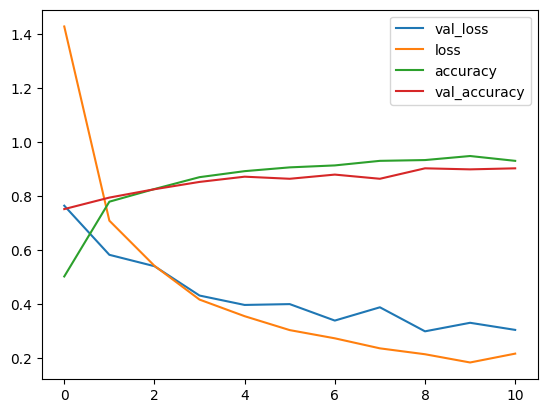

In [12]:
# Plotting the model losses and accuracies
plt.plot(np.arange(0, 11), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, 11), history.history['loss'], label = 'loss')
plt.plot(np.arange(0, 11), history.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(0, 11), history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [16]:
# Saving the model
model.save("maskclassifier.model", save_format = "h5")